## 간단한 경주

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from tqdm import trange

np.random.seed(42)
random_state = np.random.get_state()

In [2]:
class BOARD_TYPE(Enum):
    NORMAL = 0
    WALL = 1
    START = 2
    GOAL = 3

In [3]:
BOARD = [
    [BOARD_TYPE.WALL,   BOARD_TYPE.WALL,    BOARD_TYPE.NORMAL,  BOARD_TYPE.GOAL],
    [BOARD_TYPE.WALL,   BOARD_TYPE.WALL,    BOARD_TYPE.NORMAL,  BOARD_TYPE.GOAL],
    [BOARD_TYPE.WALL,   BOARD_TYPE.NORMAL,  BOARD_TYPE.NORMAL,  BOARD_TYPE.WALL],
    [BOARD_TYPE.WALL,   BOARD_TYPE.NORMAL,  BOARD_TYPE.NORMAL,  BOARD_TYPE.WALL],
    [BOARD_TYPE.NORMAL, BOARD_TYPE.NORMAL,  BOARD_TYPE.NORMAL,  BOARD_TYPE.WALL],
    [BOARD_TYPE.NORMAL, BOARD_TYPE.NORMAL,  BOARD_TYPE.WALL,    BOARD_TYPE.WALL],
    [BOARD_TYPE.NORMAL, BOARD_TYPE.NORMAL,  BOARD_TYPE.WALL,    BOARD_TYPE.WALL],
    [BOARD_TYPE.START, BOARD_TYPE.START,  BOARD_TYPE.WALL,    BOARD_TYPE.WALL]]
BOARD = np.asarray(BOARD)

In [4]:
class Environment():
    def __init__(self, board=BOARD, board_type=BOARD_TYPE):
        self.board = board
        self.board_type = board_type
        self.height, self.width = self.board.shape

        self.start = np.argwhere(self.board == self.board_type.START)
        self.start_count = len(self.start)

        self.actions = [ np.array([ 0, -1]), np.array([-1, 0]), np.array([ 0, 1]), np.array([ 1, 0]) ]
        self.action_count = len(self.actions)
        self.action_figs = [ "←", "↑", "→", "↓" ]

    def reset(self):
        return self.start[np.random.choice(self.start_count)]

    def is_inbound(self, state):
        y, x = state
        if 0 <= y < self.height and 0 <= x < self.width:
            return self.board[y, x] != self.board_type.WALL
        return False

    def step(self, state, action):
        y, x = state
        new_state = state + action

        if self.board[y, x] == self.board_type.GOAL:
            return True, -1, None
        elif not self.is_inbound(new_state):
            return False, -1, self.reset()
        return False, -1, new_state

    def plot_trajectory(self, trajectory):
        route = np.zeros((self.height, self.width))
        route[np.where(self.board == self.board_type.WALL)] = -1
        rewards = 0
        for here, _, reward, _ in trajectory:
            y, x = here
            route[y, x] = 1
            rewards += reward
        
        plt.imshow(route)
        plt.title("Rewards : {}".format(rewards))
        plt.show()
    
    def plot_state(self, state):
        route = np.zeros((self.height, self.width))
        route[np.where(self.board == self.board_type.WALL)] = -1

        y, x = state
        route[y, x] = 1        
        
        plt.imshow(route)
        plt.show()

    def plot_state_list(self, state_list):
        route = np.zeros((self.height, self.width))
        route[np.where(self.board == self.board_type.WALL)] = -1

        for y, x in states:
            route[y, x] = 1
        
        plt.imshow(route)
        plt.show()

In [5]:
class Agent():
    def __init__(self, board_shape, action_count, initial=0.0, epsilon=0.1, gamma=1.0):
        self.epsilon = epsilon
        self.gamma = gamma
        self.action_count = action_count

        self.height, self.width = board_shape
        self.q_values = np.zeros((self.height, self.width, self.action_count)) + initial
        self.c_values = np.zeros((self.height, self.width, self.action_count))

    def get_best_action(self, state):
        y, x = state
        max_value = np.max(self.q_values[y, x, :])
        action_indices = np.argwhere(max_value == self.q_values[y, x, :]).flatten()
        return np.random.choice(action_indices)
    
    def target_policy(self, state):
        best_action_index = self.get_best_action(state)
        return best_action_index, 1.0

    def behavior_policy(self, state):
        best_action_index, _= self.target_policy(state)

        if np.random.sample() < self.epsilon:
            action_index = np.random.choice(self.action_count)
            if best_action_index != action_index:
                return action_index, self.epsilon / self.action_count

        return best_action_index, 1.0 - self.epsilon + self.epsilon / self.action_count

In [6]:
def play_episode(env, agent, start=None, use_target_policy=False):
    trajectory = []
    actions = env.actions

    here = env.reset()
    if start is not None:
        here = start
        
    while True:
        if use_target_policy:
            action_index, action_prob = agent.target_policy(here)
        else:
            action_index, action_prob = agent.behavior_policy(here)
            
        action = env.actions[action_index]
        done, reward, next = env.step(here, action)
        
        trajectory.append([here, (action_index, action_prob), reward, next])

        if done:
            break
        here = next

    return trajectory

In [7]:
def monte_carlo_off_policy_control(env=None, agent=None, runs=10000):
    if None in (env, agent):
        env = Environment()
        agent = Agent(env.board.shape, epsilon=epsilon, action_count=env.action_count)


    c_values = agent.c_values
    q_values = agent.q_values

    for _ in trange(runs):
        trajectory = play_episode(env, agent)

        returns = 0.0
        weight = 1.0
        
        for i, (here, (action_index, action_prob), reward, next) in enumerate(reversed(trajectory)):
            y, x = here

            returns = agent.gamma * returns + reward
            c_values[y, x, action_index] = c_values[y, x, action_index] + weight
            q_values[y, x, action_index] = \
                q_values[y, x, action_index] + weight / c_values[y, x, action_index] * (returns - q_values[y, x, action_index])

            best_action_index = agent.get_best_action(here)

            if action_index != best_action_index:
                break
            weight = weight / action_prob
        
    return env, agent

In [8]:
np.random.set_state(random_state)

env = Environment(board=BOARD, board_type=BOARD_TYPE)
agent = Agent(env.board.shape, env.action_count, initial=-1e+10, epsilon=0.3, gamma=1.0)
env, agent = monte_carlo_off_policy_control(env, agent, runs=10000)

100%|██████████| 10000/10000 [00:17<00:00, 562.39it/s]


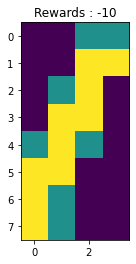

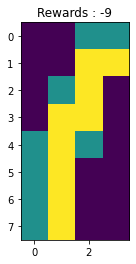

In [9]:
trajectory_0 = play_episode(env, agent, use_target_policy=True, start=[7,0])
trajectory_1 = play_episode(env, agent, use_target_policy=True, start=[7,1])
env.plot_trajectory(trajectory_0)
env.plot_trajectory(trajectory_1)